In [1471]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import re, time
from pandas_summary import DataFrameSummary
import warnings, requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
#plotly.tools.set_credentials_file(username='', api_key='')

sns.set_style('white')
sns.set(font_scale=1.7)
pd.set_option('display.max_colwidth', 50)

## Exploratory Analysis

### Get Data

Let us begin by importing the preprocessed dataset for movies with release year >= 2010. This dataset is an output of the final_data_processing.py script.

In [1472]:
df = pd.read_csv('data/df_final.csv')

In [1473]:
df.columns

Index(['title', 'num_peaks', 'search_mean', 'search_volume', 'budget',
       'genres', 'original_language', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'weekend_rev',
       'num_theaters', 'success', 'day', 'month', 'holiday', 'year', 'views',
       'likes', 'dislikes', 'dt_main', 'dt_trailers', 'dt_trailers_cat'],
      dtype='object')

In [1474]:
df.corr()

,num_peaks,search_mean,search_volume,budget,runtime,weekend_rev,num_theaters,success,holiday,year,views,likes,dislikes,dt_main,dt_trailers
num_peaks,1.000000,0.659220,0.660293,-0.090667,-0.057474,-0.115106,-0.168924,-0.135409,-0.005508,-0.062876,-0.056151,-0.066285,-0.055864,0.164708,0.152927
search_mean,0.659220,1.000000,0.999215,-0.033524,-0.012452,-0.037299,-0.037113,-0.070647,-0.028445,-0.051099,0.003370,-0.028943,-0.026276,0.176107,0.059582
search_volume,0.660293,0.999215,1.000000,-0.027136,-0.012258,-0.033510,-0.033384,-0.070712,-0.029023,-0.046673,0.005787,-0.024723,-0.025353,0.179077,0.058338
budget,-0.090667,-0.033524,-0.027136,1.000000,0.268034,0.638513,0.566100,-0.084779,-0.102136,-0.032068,0.182431,0.221011,0.155985,0.135846,-0.170116
runtime,-0.057474,-0.012452,-0.012258,0.268034,1.000000,0.135838,0.025121,-0.111369,0.098353,0.142127,-0.004470,0.027156,0.004844,-0.015357,-0.031220
weekend_rev,-0.115106,-0.037299,-0.033510,0.638513,0.135838,1.000000,0.703478,0.305695,-0.162299,-0.079691,0.087509,0.144457,0.017771,0.093818,-0.173165
num_theaters,-0.168924,-0.037113,-0.033384,0.566100,0.025121,0.703478,1.000000,0.316171,-0.117101,-0.068394,0.045345,0.082915,0.003385,0.000392,-0.142930
success,-0.135409,-0.070647,-0.070712,-0.084779,-0.111369,0.305695,0.316171,1.000000,0.015419,-0.116226,0.047513,0.032664,-0.012641,-0.034232,0.002489
holiday,-0.005508,-0.028445,-0.029023,-0.102136,0.098353,-0.162299,-0.117101,0.015419,1.000000,0.003123,0.019026,-0.001806,-0.048411,0.050931,-0.026448
year,-0.062876,-0.051099,-0.046673,-0.032068,0.142127,-0.079691,-0.068394,-0.116226,0.003123,1.000000,0.040758,0.130598,0.078493,0.073287,-0.071415


We see that features such as likes, views and dislikes are somewhat correlated with weekend revenue.


### Youtube views, likes, dislikes

In [1475]:
df['log_dislikes'] = df[df.dislikes!=0].dislikes.apply(np.log10)
df['log_likes'] = df[df.likes!=0].likes.apply(np.log10)
df['log_views'] = df[df.views!=0].views.apply(np.log10)

Let us plot some distributions after log-transforming

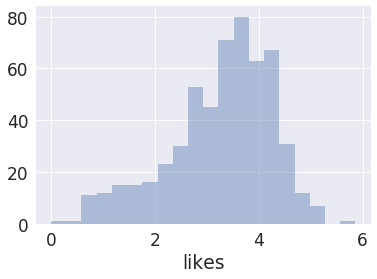

In [1476]:
sns.distplot(df.likes.apply(np.log10), kde=False)

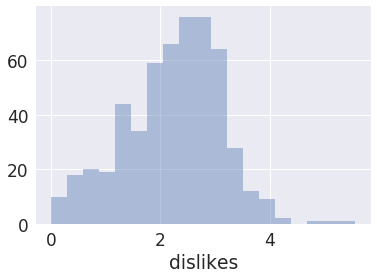

In [1477]:
sns.distplot(df[df.dislikes!=0].dislikes.apply(np.log10), kde=False)

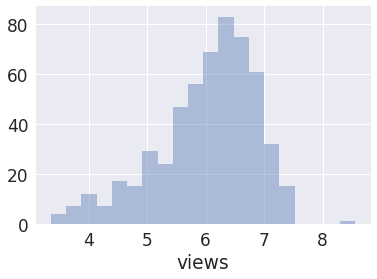

In [1478]:
sns.distplot(df[df.views!=0].views.apply(np.log10), kde=False)

There is a moderate linear correlation between the log(views) and log(weekend_rev)

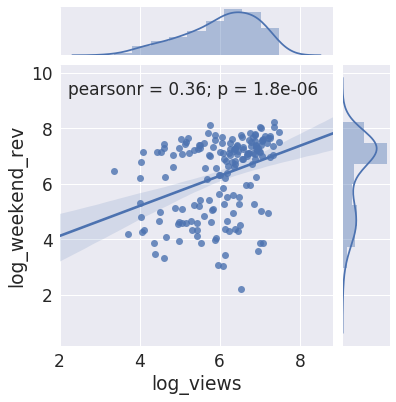

In [1479]:

p = sns.jointplot('log_views', 'log_weekend_rev', data=df_final[df_final.dt_trailers_cat =='neg'], kind="reg")

plt.show()

### Production Countries

In [1480]:
# create list that includes all countries involved in the movie data set
countries = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
countries.name = 'countries'

In [1481]:
countries_df = df.drop('production_countries', axis=1).join(countries)
countries_df = pd.DataFrame(countries_df['countries'].value_counts())
countries_df['country'] = countries_df.index
countries_df.columns = ['num_movies', 'country']
countries_df = countries_df.reset_index().drop('index', axis=1)
countries_df.head(10)
countries_df = countries_df[countries_df['country'] != 'United States of America']

In [1482]:
df.genres.head()

0    [{'id': 12, 'name': 'Adventure'}, {'id': 18, '...
1    [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
4    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
Name: genres, dtype: object

### Production Studios

Let us see what are the top production companies (with largest average "success" per movies they produce)

In [1483]:
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].apply(
    lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

com_df = df.drop('production_companies', axis=1).join(s)

In [1484]:
com_sum = pd.DataFrame(com_df.groupby('companies')['success'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['success'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['success'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

In [1485]:
com_mean.head()

,Average
companies,
Solana Films,9.957961
Haunted Movies,8.847643
Room 101,8.157205
Possessed Pictures,6.002545
Extension 765,5.589596


Seems like studios that produce predominantly horror films have large success rates. We will eplore this more below when we look into the genres.

### Release Date

Is there a relation between release dates and success?

In [1486]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [1487]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [1488]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [1489]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

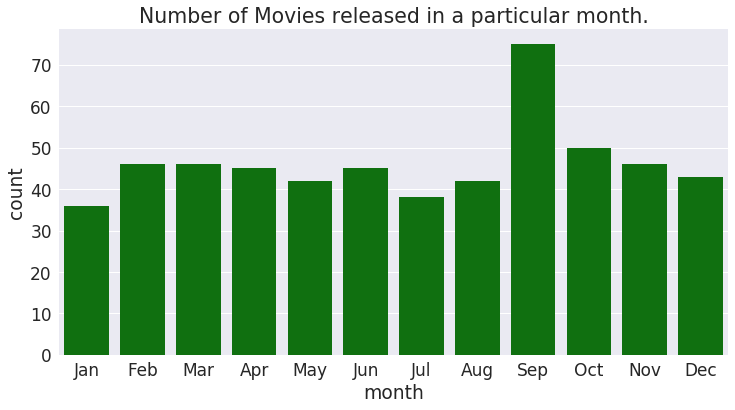

In [1490]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=df, order=month_order, color='green')

In [1491]:
#plt.figure(figsize=(12,6))
#plt.title("Number of Movies released in a particular day.")
#sns.countplot(x='day', data=df, order=day_order)

(0, 1.75)

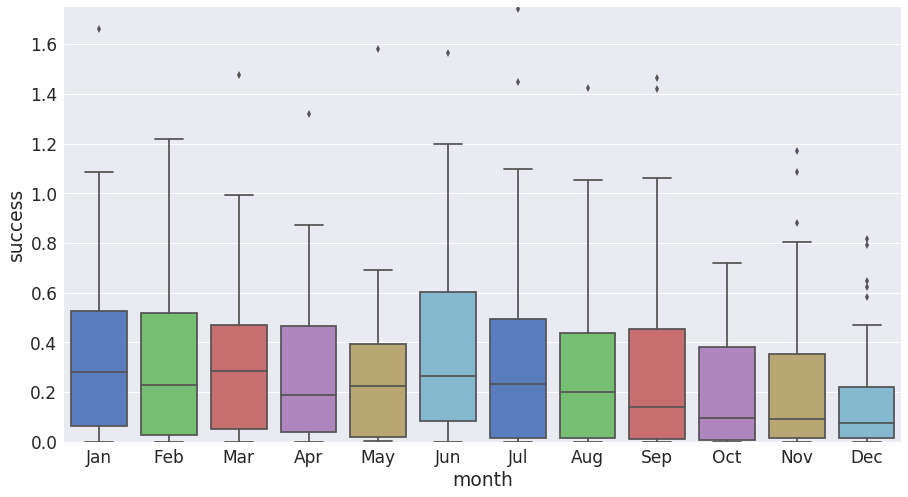

In [1492]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='month', y='success', data=df[df['success'].notnull()], palette="muted", ax =ax, order=month_order)
ax.set_ylim([0, 1.75])

Seems like movies released in June do better

### Budget

In [1493]:
df['budget'].describe()

count    5.540000e+02
mean     3.807791e+07
std      4.286572e+07
min      1.030064e+06
25%      9.000000e+06
50%      2.000000e+07
75%      5.000000e+07
max      2.090000e+08
Name: budget, dtype: float64

Text(0.5,0,'Budget Distribution (dollars)')

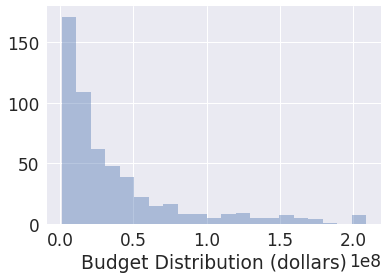

In [1494]:
p = sns.distplot(df[df['budget'].notnull()]['budget'], kde=False)
p.set_xlabel('Budget Distribution (dollars)')

In [1495]:
df['log_budget']= df['budget'].apply(np.log10)
df['log_weekend_rev']= df['weekend_rev'].apply(np.log10)

The log of the budget seems to be sort of normally distributed. Not so for the log of the weekend revenue though:

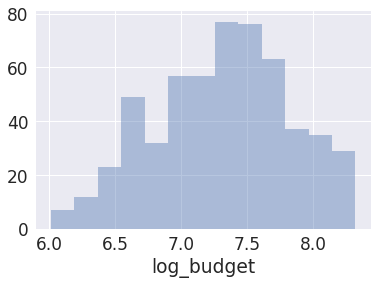

In [1496]:
sns.distplot(df[df['log_budget'].notnull()]['log_budget'], kde=False)

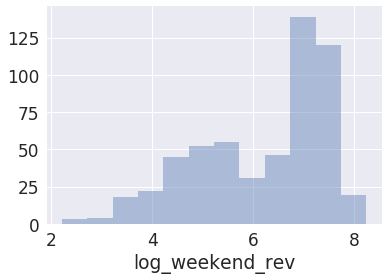

In [1497]:
sns.distplot(df[df['log_weekend_rev'].notnull()]['log_weekend_rev'], kde=False)

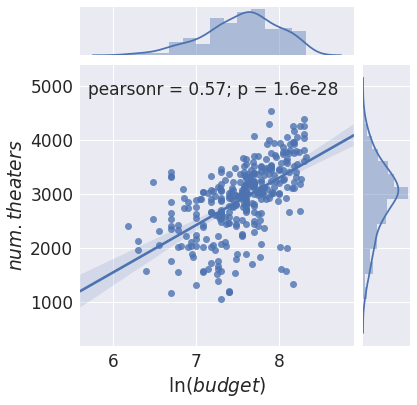

In [1498]:
p=sns.jointplot('log_budget', 'num_theaters', data=df_final[df_final.num_theaters>1000], kind='reg')
p.set_axis_labels(r'$\ln(budget)$', r'$num. theaters$')
plt.show()

### Genre

Let us explore the movie genres. Does one genre correlate mroe with success than the rest?

In [1499]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(
    lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

gen_df = df.drop('genres', axis=1).join(s)

gen_df['genre'].value_counts().shape[0]

18

In [1500]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)

,genre,movies
0,Drama,299
1,Comedy,189
2,Thriller,154
3,Action,128
4,Romance,81
5,Adventure,79
6,Crime,66
7,Science Fiction,58
8,Horror,49
9,Family,48


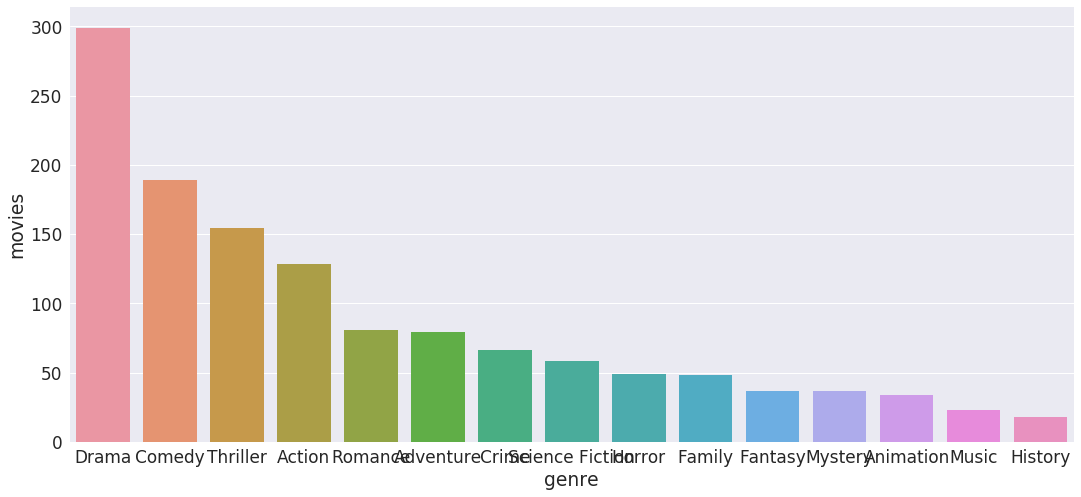

In [1501]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.show()

In [1502]:
genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime',
          'Adventure', 'Science Fiction', 'Mystery', 'Fantasy', 'Mystery', 'Animation']

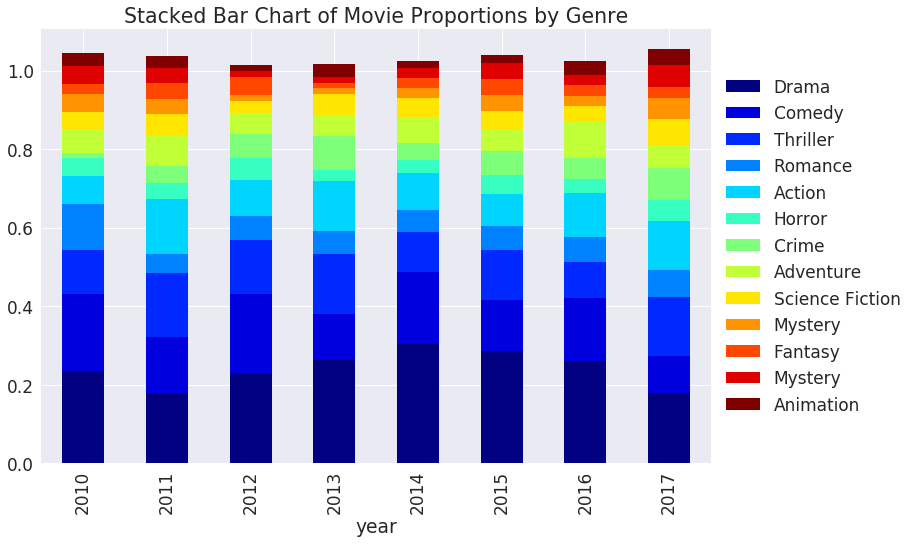

In [1503]:
pop_gen_movies = gen_df[(gen_df['genre'].isin(genres))]
ctab = pd.crosstab([pop_gen_movies['year']], pop_gen_movies['genre']).apply(lambda x: x/x.sum(), axis=1)
ctab[genres].plot(kind='bar', stacked=True, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Stacked Bar Chart of Movie Proportions by Genre")
plt.show()

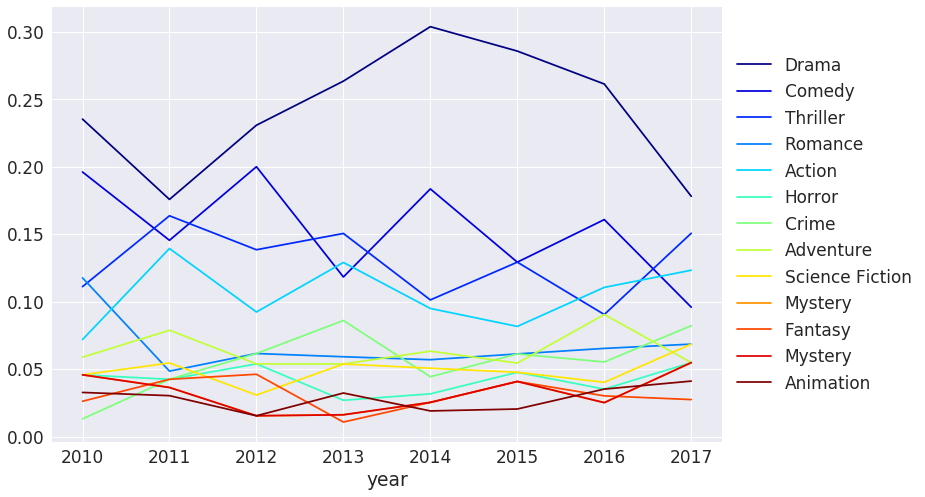

In [1504]:
ctab[genres].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [1505]:
violin_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
violin_movies = gen_df[(gen_df['genre'].isin(violin_genres))]

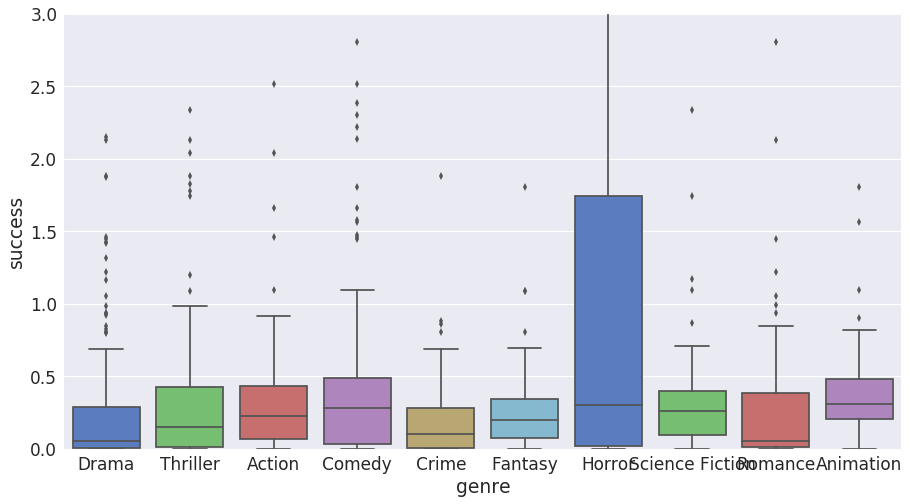

In [1506]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='success', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 3])
sns.set(font_scale=1.2)
plt.show()

Low budget horror films aparently can lead to success! Indeed, the movie paranormal activity had a budget of 3 million dollars and generated about 40 million on opening weekend.

In [1507]:
df.budget[df.title=='Paranormal Activity 2'], df.weekend_rev[df.title=='Paranormal Activity 2'], df.success[df.title=='Paranormal Activity 2']

(359    3000000
 Name: budget, dtype: int64, 359    40678424
 Name: weekend_rev, dtype: int64, 359    13.559475
 Name: success, dtype: float64)

and all of the top 5 movies with largest success are horror films!

In [1613]:
pd.DataFrame(df_final.sort_values('success', ascending=False).title).reset_index(drop=True)[:10]

,title
0,Paranormal Activity 2
1,Paranormal Activity 3
2,Insidious
3,Sinister
4,Paranormal Activity 4
5,Magic Mike
6,Ouija
7,Silent House
8,Think Like a Man
9,Jackass 3D


### runtime

Most movies run for more than 80 minutes, so we could inpute the short films. 

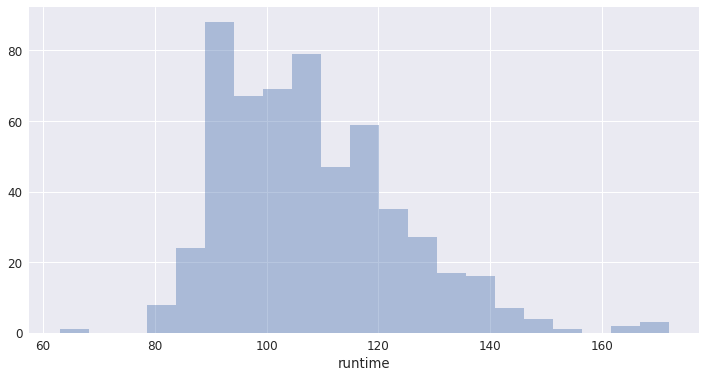

In [1509]:
df['runtime'] = df['runtime'].astype('float')
df['runtime'].describe()
plt.figure(figsize=(12,6))
sns.distplot(df[(df['runtime'] < 300) & (df['runtime'] > 0)]['runtime'], kde=False)

## Google trends

Let us explore the google trends data

In [1510]:
def google_trends(title):
    query = title + ' ' + 'trailer'
    kw_list = [query]
    pytrends.build_payload(kw_list, cat=0, timeframe='today 12-m', geo='US', gprop='youtube')
    data_df = pytrends.interest_over_time().reset_index()
    
    if 'isPartial' in data_df.columns:
        data_df.drop('isPartial', axis = 1, inplace=True)    
    data_df.columns = ['dates', 'searches']
    return data_df

In [1511]:
#get movie data for movies released >= 2010 and with production countries always including the US.
#df = pd.read_csv('data/data_since_2010.csv')
#df.drop('Unnamed: 0', axis =1, inplace=True)

# import data 
searches = pd.read_csv('data/searches') #first take
searches2010 = pd.read_csv('searches2010')[1:] #second take

searches2010_monthly = pd.read_csv('searches2010_monthly')
searches2010_monthly.drop_duplicates(inplace=True)
searches2010_monthly.set_index('dates', inplace = True)
searches_total_volume = searches2010_monthly.groupby('title').searches.apply(sum)
searches2010_monthly.searches = searches2010_monthly.searches.astype(int)

searches = pd.concat([searches2010, searches]).drop_duplicates()

searches.set_index('dates', inplace = True)
searches.drop('dates', inplace = True)

#drop duplicates
searches.reset_index(inplace=True)
searches.drop_duplicates(inplace=True)
searches.set_index('dates', inplace = True)
searches.index =pd.DataFrame(searches.index).apply(lambda x: pd.to_datetime(x, format='%Y/%m/%d')).dates

def get_peaks(x,thres, min_dist):
    '''return the indices of the top peaks and their values in the google trends.
        to be uses when perfoming groupby below'''
    import peakutils
    data = x.values
    baseline_values = peakutils.baseline(data)
    data_without_baseline = data - baseline_values
    peakind = peakutils.indexes(data_without_baseline, thres=thres, min_dist=min_dist)
    dates = x.index
    dates_series = pd.Series(dates)
    data_df = pd.DataFrame(data)
    #peak_values = list(data_df.loc[peakind].values)
    peak_dates = dates_series[peakind]
    peak_values = data[peakind]
    
    return pd.DataFrame({'peak_dates':peak_dates, 'peak_values':peak_values})

searches.searches = searches.searches.astype(int)

# find the peak index location for each peak
g = searches.groupby('title')
peaks_series = g['searches'].apply(lambda x: get_peaks(x, thres=0.20, min_dist=8))
search_volume = g['searches'].apply(sum)
search_mean = g['searches'].apply(np.mean)

def get_movie(title):
    return searches.loc[searches.title==title]['searches'].copy()

In [1512]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy
import peakutils
title = 'Gangster Squad'
dates = searches.groupby('title').groups[title]
series = pd.Series(get_movie(title).values)
series.set_axis(dates, inplace = True)
indices = list(peaks_series.loc[title].peak_dates.values)

trace = go.Scatter(
    x = dates,
    y= series.values,
    mode='lines',
    name='Search Volume'.format(title)
)

trace2 = go.Scatter(
    x=series[indices].index,
    y=series[indices].values,
    mode='markers',
    marker=dict(
        size=10,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Maxima'
        
)

data = [trace, trace2]
layout = go.Layout(
    title='Search Volume for \"{} trailer\" on  Google Trends '.format(title),
    xaxis=dict(
        title='The year prior to opening weekend',
        titlefont=dict(
            family='Courier New, monospace',
            size=26,
            color='#black'
        ),
        showticklabels=True,
        tickangle=0,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=20,
            color='black'
        ),
    ),
    yaxis=dict(
        title='Search Volume (Normalized)',
        titlefont=dict(
            family='Courier New, monospace',
            size=26,
            color='black'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(data, filename=title)
#plot_url = py.plot(fig, filename='trailers')

Does it matter tif the largest peak appears first or second?

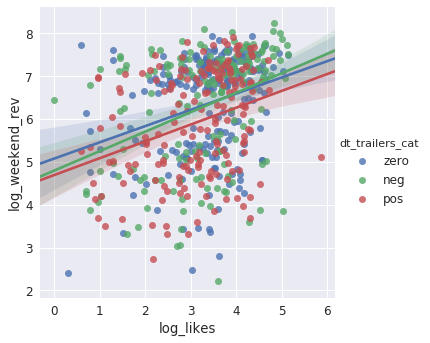

In [1513]:
sns.lmplot(x="log_likes", y="log_weekend_rev", hue="dt_trailers_cat", data=df_final);

In [1514]:
df_final.columns

Index(['title', 'num_peaks', 'search_mean', 'search_volume', 'budget',
       'genres', 'original_language', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'weekend_rev',
       'num_theaters', 'success', 'day', 'month', 'holiday', 'year', 'views',
       'likes', 'dislikes', 'dt_main', 'dt_trailers', 'dt_trailers_cat',
       'log_dislikes', 'log_likes', 'log_views', 'log_budget',
       'log_weekend_rev'],
      dtype='object')

(array([171.,   0.,   0.,   0.,   0., 174.,   0.,   0.,   0., 209.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

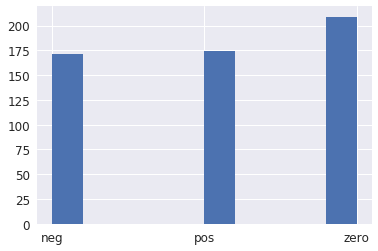

In [1515]:
plt.hist(df_final['dt_trailers_cat'])

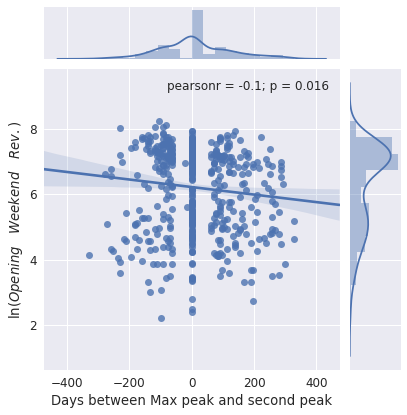

In [1516]:
p=sns.jointplot('dt_trailers', 'log_weekend_rev', data=df_final, kind='reg')
p.set_axis_labels('Days between Max peak and second peak', r'$\ln(Opening\quad Weekend\quad Rev.)$')
plt.show()

Seems like movie studios tend to release trailers 15 weeks appart (we just look at the top two trailers).

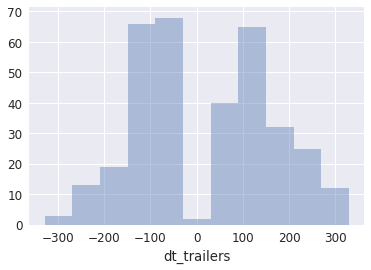

In [1250]:
sns.distplot(df[df['dt_trailers']!=0].dt_trailers, kde=False)

Seems like movies where the first trailer had more search volume, tend to have larger success.

Text(0.5,0,'Days from best trailer to release date')

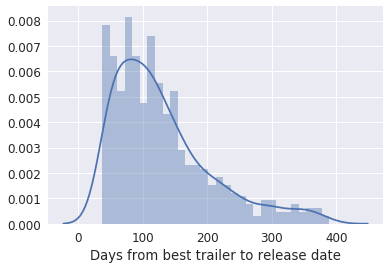

In [1251]:
sns.distplot(df_final['dt_main'], bins=30)
plt.xlabel('Days from best trailer to release date')

Seems like movie trailers are typically released about 3 months prior to release date.

## Models

In [1591]:
df = pd.read_csv('data/df_final.csv')
#df= df[df.success<=1]
df= df[df.budget>=10000000]
df = df[df.num_peaks<3]
df = df[df.runtime>80]

In [1592]:
#df['log_dislikes'] = df[df.dislikes!=0].dislikes.apply(np.log10)
#df = df.drop(['dislikes'], axis=1)
#df['log_likes'] = df[df.likes!=0].likes.apply(np.log10)
#df = df.drop(['likes'], axis=1)
#df['log_views'] = df[df.views!=0].views.apply(np.log10)
#df = df.drop(['views'], axis=1)
df['log_budget'] = df[df.budget!=0].budget.apply(np.log10)
df = df.drop(['budget'], axis=1)
#df['log_search_volume'] = df[df.search_volume!=0].search_volume.apply(np.log10)
#df = df.drop(['search_volume'], axis=1)

In [1593]:
df.columns

Index(['title', 'num_peaks', 'search_mean', 'search_volume', 'genres',
       'original_language', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'weekend_rev', 'num_theaters', 'success',
       'day', 'month', 'holiday', 'year', 'views', 'likes', 'dislikes',
       'dt_main', 'dt_trailers', 'dt_trailers_cat', 'log_budget'],
      dtype='object')

In [1594]:
#df = df.drop(['search_mean', 'release_date', 'weekend_rev', 'dt_trailers_cat', 'runtime'], axis=1)
df = df.drop(['search_mean', 'release_date', 'weekend_rev', 'dt_trailers_cat', 'runtime'], axis=1)

In [1595]:
df.columns

Index(['title', 'num_peaks', 'search_volume', 'genres', 'original_language',
       'production_companies', 'production_countries', 'num_theaters',
       'success', 'day', 'month', 'holiday', 'year', 'views', 'likes',
       'dislikes', 'dt_main', 'dt_trailers', 'log_budget'],
      dtype='object')

In [1596]:
df.shape

(270, 19)

In [1597]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(s)
genres_train = gen_df['genre'].drop_duplicates()

In [1598]:
def feature_engineering(df):
    for genre in genres_train:
        df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
    df['genres'] = df['genres'].apply(lambda x: len(x))    
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    #df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov', 'Dec'] else 0)
    df = df.drop('month', axis=1)
    df = pd.get_dummies(df, prefix='is')
    df['neg'] = pd.get_dummies(df_final.dt_trailers_cat).neg
    df['neg'] = pd.get_dummies(df_final.dt_trailers_cat).pos
    df['zero'] = pd.get_dummies(df_final.dt_trailers_cat).zero
    #df['search_proxy'] = df['views_proxy']*df['search_volume']*df['likes']/(df['likes'] +df['dislikes'])
    #df.drop(['likes', 'dislikes', 'views_proxy', 'search_volume'], axis=1, inplace=True)
    #df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    return df

In [1599]:
X, y = df.drop('success', axis=1), df['success']

In [1600]:
df.columns

Index(['title', 'num_peaks', 'search_volume', 'genres', 'original_language',
       'production_companies', 'production_countries', 'num_theaters',
       'success', 'day', 'month', 'holiday', 'year', 'views', 'likes',
       'dislikes', 'dt_main', 'dt_trailers', 'log_budget'],
      dtype='object')

In [1601]:
num_vars = ['num_peaks', 'search_volume',  'likes', 'dislikes', 'num_theaters', 'dt_main']
#num_vars = ['num_peaks', 'log_search_volume',  'log_likes', 'log_dislikes', 'log_budget', 'num_theaters', 'dt_main']

In [1602]:
X = feature_engineering(X)
features = X.columns

In [1603]:
scaler = StandardScaler().fit(X[num_vars])

In [1604]:
#X = pd.DataFrame(scaler.transform(X[num_vars]), columns = num_vars)

In [1605]:
X = np.nan_to_num(X)

In [1606]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [1607]:
#X_train, X_test, X_test_holdout = np.split(X.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [1608]:
reg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=330, subsample=1,
                                criterion='friedman_mse', min_samples_split=2, min_samples_leaf=2, 
                                min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0)
y_pred = cross_val_predict(reg, X, y, cv=10)

reg.fit(X_train, y_train)
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))


0.9978941903557983
0.43370347547028376


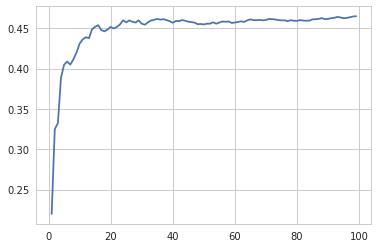

In [1544]:

params = list(range(1,100))
clf = GridSearchCV(reg, {'n_estimators': params})
_=clf.fit(X, y)
plt.plot(params, clf.cv_results_['mean_test_score'])

In [1609]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

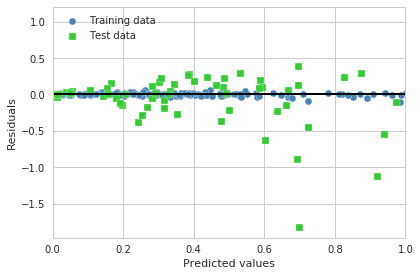

In [1610]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([0, 1])
plt.tight_layout()

# plt.savefig('images/10_09.png', dpi=300)
plt.show()

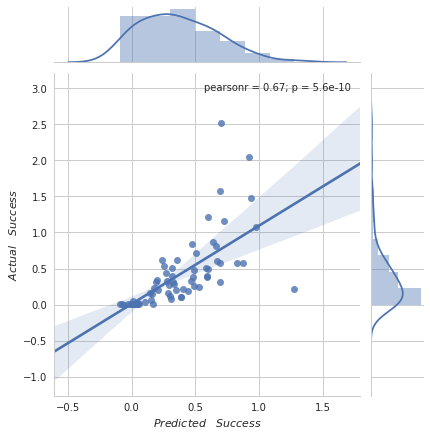

In [1611]:
y_pred = reg.predict(X_test)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
p=sns.jointplot(y_pred, y_test, kind='reg')
p.set_axis_labels(
    r'$ Predicted\quad Success$', r'$ Actual\quad Success$')

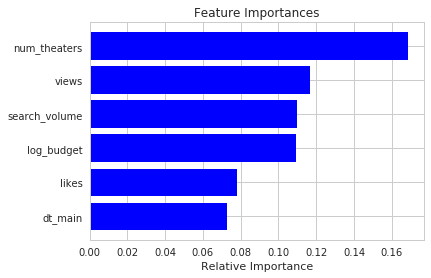

In [1612]:
importances = reg.feature_importances_
indices = np.argsort(importances)[-6:]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
#Random forest
# from sklearn.ensemble import RandomForestRegressor

# forest = RandomForestRegressor(n_estimators=50, min_samples_split=4,
#                                criterion='mse', 
#                                random_state=1, 
#                                n_jobs=-1)
# forest.fit(X_train, y_train)
# y_train_pred = forest.predict(X_train)
# y_test_pred = forest.predict(X_test)

# print('MSE train: %.3f, test: %.3f' % (
#         mean_squared_error(y_train, y_train_pred),
#         mean_squared_error(y_test, y_test_pred)))
# print('R^2 train: %.3f, test: %.3f' % (
#         r2_score(y_train, y_train_pred),
#         r2_score(y_test, y_test_pred)))